In [1]:
import os
import os.path as osp
def find_root_folder(starting_path = os.getcwd()):
    from os.path import isfile, join, dirname
    path = starting_path
    i = 0
    found = False
    while i < 100:
        found = ('LICENSE' in [f for f in os.listdir(path) if isfile(join(path, f))])
        if found:
            break
        else:
            i += 1
            path = dirname(path)            
    if found:
        print(f"Found directory with license at {path}")
    else:
        raise FileNotFoundError("Could not find LICENSE file in ancestral directory")
    return path
ROOT_FOLDER = find_root_folder()
DS_FOLDER = osp.join(ROOT_FOLDER,'kddbr-2022')

# Arguments. Some are unused
DEVICE = 'cuda'
FOLD_SPLITS = 10
WHICH_VAL_FOLD = 0
RANDOM_STATE = 123
DEBUG = False
BATCH_SIZE = 128
NUM_EPOCHS = 200
VAL_EPOCH = 5



In [2]:
import torch
import pandas as pd
import os.path as osp
import numpy as np
import torchvision
from torchvision.transforms import Normalize
from torch import tensor
import matplotlib.pyplot as plt
from tqdm import tqdm, trange
from PIL import Image

"""
Dataframe setup
"""
import sklearn
from sklearn.model_selection import KFold
def setup_dataframes():
    df = pd.read_csv(osp.join(DS_FOLDER, 'public.csv'))
    df_test, df_train = df[pd.isna(df.East)].reset_index(drop=True), df[~pd.isna(df.East)].reset_index(drop=True)
    del df
    # Use K-Fold to separate between training and test
    kf = KFold(n_splits=FOLD_SPLITS,shuffle=True,random_state=RANDOM_STATE)
    N_trainval = df_train.shape[0]
    for i,(train_idx, val_idx) in enumerate(kf.split(np.arange(N_trainval)[:,None])):
        if i == WHICH_VAL_FOLD:
            df_val = df_train.loc[val_idx,:].reset_index(drop=True)
            df_train = df_train.loc[train_idx,:].reset_index(drop=True)

    return {'train': df_train, 'val':df_val, 'test':df_test}

#  Get Dataframe dictionary
dfs = setup_dataframes()


<h3> After inspecting the dataset, it became clear that each image is a part of a recording of a drone in a certain flight trajectory.</h3> Because these frames are consecutive, they are correlated. <br/> Therefore, we must find a way to recover this temporal information, so that we can properly split the dataset into different episodes and minimize the overly optimistic validation.

<h3> How to do this? </h3>
Well, we are fortunate to have the altitude encoded as metadata, as well as the delta between frames. So, to find the next frame, we can check if any of the data

In [137]:
import matplotlib.pyplot as plt

def get_path(fname, ds_folder=DS_FOLDER):
    train_path = osp.join(ds_folder,'train','train', fname)
    test_path = osp.join(ds_folder,'test','test', fname)
    return train_path if osp.isfile(train_path) else test_path

def get_image(fname, ds_folder=DS_FOLDER):
    fpath = get_path(fname, ds_folder=ds_folder)
    return np.array(Image.open(fpath))
def plot_image(fname):
    plt.imshow(get_image(fname))
    plt.show()

# SELECT YOUR MODE HERE!!!
MODE = 'train'

df_og = pd.read_csv(osp.join(DS_FOLDER, 'public.csv'))
if MODE == 'train':
    df = df_og[~pd.isna(df_og['North'])]
else:
    df = dfs['test'].copy()
    
step = 0   
df['step'] = -1
df['diff'] = 0.0
display(df)
current_id = 0
df['step'].values[current_id] = step
num_breaks = 0
for _ in trange(df.shape[0]-1):

    # New step
    step += 1
    # Get altitude+delta, calculate new altitude
    altitude, delta = df['Altitude'].values[current_id], df['Delta'].values[current_id]
    new_altitude = altitude + delta
    df['Altitude'].values[current_id] = -99999
    
    # Do we have any exact matches?
    zero_ids = np.where(np.abs(df['Altitude'].values - new_altitude) == 0)[0]
    # What is the difference in altitude between the predicted one and the best match?
    diff = np.min(np.abs(df['Altitude'].values - new_altitude))
    
    if len(zero_ids) == 1 :
        # Found exactly one match for this altitude. We'll assume it is the next frame in the video
        current_id = zero_ids[0]
    else:
        # Alright, 0 or more than 1 match. Let's get the ids for the 100 closest altitudes
        candidate_ids = np.argsort(np.abs(df['Altitude'].values - new_altitude))[:100]
        # For each of these candidates, we'll select the one with lowest squared error to the image.
        # Hopefully, this will be the image of the next or nearby frame.
        target = np.reshape(dct[df['Filename'].values[current_id]][:,120:,:],(1,-1))
        candidates = np.concatenate([np.reshape(dct[k][:,:120,:],(1,-1)) for k in df['Filename'].values[candidate_ids] ])
        errors = np.mean(np.square(target-candidates),-1)
        current_id = candidate_ids[np.argmin(errors)]
        
    df['step'].values[current_id] = step  
    df['diff'].values[current_id] = diff
    

if MODE == 'train':
    df['Altitude'] = df_og[~pd.isna(df_og['North'])]['Altitude']
else:
    df['Altitude'] = dfs['test'].copy()['Altitude']


,Filename,Altitude,Delta,North,East,step,diff
0,000053b1e684c9e7ea73727b2238ce18.jpg,167.943069,0.010269,NaN,NaN,-1,0.0
1,00029153d12ae1c9abe59c17ff2e0895.jpg,195.853088,0.089218,NaN,NaN,-1,0.0
2,0006246bee639c7a7b11a08e34dd3cc6.jpg,146.943466,-0.018326,NaN,NaN,-1,0.0
3,00063cb5da1826febf178b669eea3250.jpg,213.184418,-0.108704,NaN,NaN,-1,0.0
4,00063ece2e68a8847f228e8fd922f851.jpg,184.757767,0.017700,NaN,NaN,-1,0.0
...,...,...,...,...,...,...,...
55026,fff87fc38496c1838a216c742e653065.jpg,191.309677,-0.509415,NaN,NaN,-1,0.0
55027,fff98e721ed96517d940eb5b2daf2d18.jpg,171.288254,0.109970,NaN,NaN,-1,0.0
55028,fff9e3be29d11366c43df7b2ae749547.jpg,196.589905,-0.118561,NaN,NaN,-1,0.0
55029,fffae68750a8bd5e6ba46b25ce7030de.jpg,176.795364,0.023209,NaN,NaN,-1,0.0


100%|████████████████████████████████████| 55030/55030 [01:29<00:00, 615.22it/s]


### Order the Dataframe by the 'step' column in ascending order, and save it as a 'flight' csv

In [138]:
df2 = df.sort_values('step')
df2['NewAlt'] = df['Altitude'] + df['Delta']
df2.to_csv(f'flight_{MODE}.csv')
print(df2['diff'].max())
display(df2)

7.4583587646484375


,Filename,Altitude,Delta,North,East,step,diff,NewAlt
12317,3922314b8050f8c35ef91dacb6ec72a1.jpg,230.478577,-0.290161,NaN,NaN,-1,0.000000,230.188416
29385,88903f12da23bba2fe342982583e7993.jpg,188.860229,-0.075989,NaN,NaN,-1,0.000000,188.784241
23469,6d12d67f199260c85d1fdafc0ebe4395.jpg,183.928680,0.421219,NaN,NaN,-1,0.000000,184.349899
19198,58d5e97be4ccb06f4d68092db08ec5be.jpg,178.813446,-0.059631,NaN,NaN,-1,0.000000,178.753815
39142,b6225444f2560ba859c24a14ccd9769c.jpg,212.381531,-0.170593,NaN,NaN,-1,0.000000,212.210938
...,...,...,...,...,...,...,...,...
54107,fb7fce873c18ddcc4625ce2e9fa064ab.jpg,178.577438,-0.019058,NaN,NaN,54942,0.000000,178.558380
425,01e91c5fa75d1dac67001b11e1d34526.jpg,178.558380,-0.017242,NaN,NaN,54943,0.000000,178.541138
25626,773dba6697ae13585ea0dc4b8b19bc8b.jpg,178.541138,-0.012421,NaN,NaN,54944,0.000000,178.528717
894,04215c1ad3aaff3ed175446d2ea3c0f2.jpg,178.528717,-0.013397,NaN,NaN,54945,0.000000,178.515320


In [139]:
import shutil

def get_path(fname, ds_folder=DS_FOLDER):
    train_path = osp.join(ds_folder,'train','train', fname)
    test_path = osp.join(ds_folder,'test','test', fname)
    return train_path if osp.isfile(train_path) else test_path

import os.path as osp
os.makedirs(osp.join(DS_FOLDER,'ordered'), exist_ok=True)

# Optional: Create 
for i in range(df2.shape[0]):
    shutil.copy2(get_path(df2['Filename'].values[i]), osp.join(DS_FOLDER,'ordered',f'{str(i).zfill(8)}.jpg'))

## Create arrow thing

100%|█████████████████████████████████████| 55031/55031 [11:00<00:00, 83.26it/s]
ffmpeg version 4.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/home/klaus/anaconda3/envs/ldm --cc=/opt/conda/conda-bld/ffmpeg_1597178665428/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
Input #0, image2, from './temp/*.jpg':
  Duration: 00:38:12.96, start

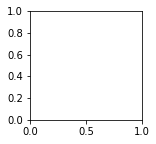

In [3]:


def get_flight_csv(mode):
    if mode == 'train':
        return pd.read_csv('./flight/flight_train.csv')
    else:
        return pd.read_csv('./flight/flight_test.csv')
def get_flight_video_path(mode):
    if mode == 'train':
        return './flight/new_flight_train.mp4' 
    else:
        return './flight/flight_test.mp4' 

        
import matplotlib.pyplot as plt


def create_arrow(mode, fpath = None, out_path = None, arrow_color='red'):
    """ Creates video of an arrow following"""
    import shutil
    if osp.isdir('./temp'):
        shutil.rmtree('./temp')
    
    # Initialize figure
    import shutil
    import matplotlib.pyplot as plt
    os.makedirs('./temp', exist_ok=True)
    df = get_flight_csv('train')
    fig, ax = plt.subplots(1,figsize=(2,2))
    ym = max(df['North'].quantile(0.9), -df['North'].quantile(0.1))
    xm = max(df['East'].quantile(0.9), -df['East'].quantile(0.1))

    # Load 'flight' csvs with correct order
    df_ref = get_flight_csv(mode)
    # And  the video containing the fly-by
    ref_video = get_flight_video_path(mode)
    
    
    if fpath is None:
        assert mode == 'train'
        df = df_ref
    else:
        df = pd.read_csv(fpath)
        if not 'Id' in df.columns:
            raise ValueError("Prediction must have column 'Id'")
        df_N, df_E = df.iloc[::2,:].copy(), df.iloc[1::2,:].copy()
        df_N['North'] = df_N['Predicted'].values
        df_N['East'] = df_E['Predicted'].values
        df_N['Filename'] = [x.split(':')[0] for x in df_N['Id']]
        df = df_ref.loc[:,['Filename','Altitude','Delta']].merge(df_N, on='Filename')        
    

    from sklearn.preprocessing import normalize as normalize_np
    for i in trange(df.shape[0]):
        north = df['North'].values[i]
        east = df['East'].values[i]
        y = np.array([north, east])
        ax.arrow(0,0,y[1],y[0], width = 0.02, head_length=0.1, head_width=0.2, length_includes_head=True,
                color=arrow_color)
        ax.set_ylim(-ym,ym)
        ax.set_xlim(-xm,xm)
        ax.axis('off')
        fig.savefig(f'./temp/{str(i).zfill(8)}.jpg',transparent=False)
        ax.clear()

    
    cmd = fr"ffmpeg -y -framerate 24 -pattern_type glob -i './temp/*.jpg' ./temp/temp.mp4"
    os.system(cmd)
    cmd = fr"ffmpeg -y -i ./temp/temp.mp4 -vf scale=120:120  ./temp/temp2.mp4"
    os.system(cmd)  
    cmd = fr"ffmpeg -y -i {ref_video} -i ./temp/temp2.mp4 -filter_complex hstack {out_path}"
    os.system(cmd)  
    
    #shutil.rmtree('./temp')
    
PRED_NAME = 'Sep29_lgb_3'
PRED_FOLDER  = osp.join(ROOT_FOLDER, 'predictions', PRED_NAME)

#create_arrow(mode='train', fpath = None, arrow_color='blue',
#            out_path = './flight/new_flight_train.mp4')

create_arrow(mode='test', fpath = osp.join(PRED_FOLDER, f'test.csv'),
            out_path = osp.join(ROOT_FOLDER, 'predictions',PRED_NAME,'arrow_test.mp4'))
#create_arrow(mode='train', fpath = osp.join(PRED_FOLDER, f'trainval.csv'),
#            out_path = osp.join(ROOT_FOLDER, 'predictions',PRED_NAME,'arrow.mp4'))

    
    

100%|█████████████████████████████████████| 91231/91231 [17:26<00:00, 87.18it/s]
ffmpeg version 4.3 Copyright (c) 2000-2020 the FFmpeg developers
  built with gcc 7.3.0 (crosstool-NG 1.23.0.449-a04d0)
  configuration: --prefix=/home/klaus/anaconda3/envs/ldm --cc=/opt/conda/conda-bld/ffmpeg_1597178665428/_build_env/bin/x86_64-conda_cos6-linux-gnu-cc --disable-doc --disable-openssl --enable-avresample --enable-gnutls --enable-hardcoded-tables --enable-libfreetype --enable-libopenh264 --enable-pic --enable-pthreads --enable-shared --disable-static --enable-version3 --enable-zlib --enable-libmp3lame
  libavutil      56. 51.100 / 56. 51.100
  libavcodec     58. 91.100 / 58. 91.100
  libavformat    58. 45.100 / 58. 45.100
  libavdevice    58. 10.100 / 58. 10.100
  libavfilter     7. 85.100 /  7. 85.100
  libavresample   4.  0.  0 /  4.  0.  0
  libswscale      5.  7.100 /  5.  7.100
  libswresample   3.  7.100 /  3.  7.100
Input #0, image2, from './temp/*.jpg':
  Duration: 01:03:21.29, start

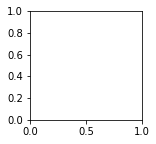

In [32]:
PRED_NAME = 'Sep24_1'
PRED_FOLDER  = osp.join(ROOT_FOLDER, 'predictions', PRED_NAME)
create_arrow(mode='train', fpath = osp.join(PRED_FOLDER, f'trainval.csv'),
            out_path = osp.join(ROOT_FOLDER, 'predictions',PRED_NAME,'arrow.mp4'))